In [14]:
import cv2
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

## ImageAugmentation

In [15]:
class ImageAugmentation:
    def __init__(self, path = "./"):
        self.dim = (64, 36)
        self.folder_list = glob.glob(path + "/*")
        self.folders = []
        for p in self.folder_list:
            self.folders.append(p.split("\\")[-1])
            
        
        
        for folder in self.folders:
            self.files = glob.glob(path + "/" + folder + "/*")
            
            for file in self.files:
                #resize
                file_name = file.split("\\")[-1]
                img = cv2.imread(path + "/" + folder + "/" + file_name)
                resized = cv2.resize(img, self.dim,interpolation=cv2.INTER_AREA)                
                cv2.imwrite(path + "/" + folder + "/" + file_name,resized)
                
                
                constraint = ["rx_", "ry_"]
                if file_name[:3] not in constraint and path.split('/')[-1] != 'test':
                    rows, cols, dim = resized.shape
                    My = np.float32([[-1,  0, cols],
                                    [0 ,  1, 0   ],
                                    [0 ,  0, 1   ]])
                    Mx = np.float32([[1,  0, 0],
                                    [0 ,  -1, rows],
                                    [0 ,  0, 1   ]])
                    #resized img reflection on y axis
                    reflected_img = cv2.warpPerspective(resized,My,(int(cols),int(rows)))
                    cv2.imwrite(path + "/" + folder + "/" + "ry_"+ file_name,reflected_img)
                    
                    #resized img reflection on x axis
                    reflected_img = cv2.warpPerspective(resized,Mx,(int(cols),int(rows)))
                    cv2.imwrite(path + "/" + folder + "/" + "rx_"+ file_name,reflected_img)
        

In [16]:
ImageAugmentation("./data/train")
ImageAugmentation("./data/test")

## Data loading

In [17]:
class CDataset(Dataset):
    def __init__(self, train = False, test = False):
        if(train):
            self.data_path = "./data/train/"
        if(test):
            self.data_path = "./data/test/"
        self.folder_list = glob.glob(self.data_path + "*")

        self.data = []
        for folder in self.folder_list:
            folder_name = folder.split("\\")[-1]
            for img_path in glob.glob(self.data_path + folder_name + "/*.jpg"):
                self.data.append([img_path, folder_name])
        self.class_map = {"Car": 0, "Truck": 1, "Bicycle": 2, "Dog": 3}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        img_path, class_name = self.data[i]
        img = cv2.imread(img_path)
        class_id = self.class_map[class_name]
        img_tensor = torch.tensor(img, dtype=torch.float)
        img_tensor = img_tensor.permute(2,0,1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [18]:
if __name__ == "__main__":
    batch_size = 5
    train_dataset = CDataset(train=True)
    data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    test_dataset = CDataset(test=True)
    data_loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## CNN

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix

In [20]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [21]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        
        self.gradients = None

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),  
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),  
            
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.6),
            nn.Linear(9216, 1028),
            nn.PReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(1028, 128),
            nn.PReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(128, len(train_dataset.class_map)),
            nn.PReLU(),
        )


    def forward(self, x): 
        x = self.conv_layer(x)
        x = torch.flatten(x, 1)
        x = self.fc_layer(x)
        return x      
    

In [22]:
net = CNN()
def calc_input_dims():
        batch_data = torch.zeros((1, 3, 64, 36))
        
        batch_data = net.conv_layer(batch_data)
        
        return int(np.prod(batch_data.size()))
calc_input_dims()

9216

In [23]:
lossF = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [24]:
net.to(device)  
epochs = 50
train_loss = []
test_loss = []

for epoch in range(epochs): 
    print("Starting epoch #" + str(epoch))
    running_loss_train = 0.0
    running_loss_test = 0.0
    net.to(torch.device("cuda:0")) 
    for i, data in enumerate(data_loader_train, 0):
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        print(inputs.shape)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = lossF(outputs, labels.flatten())
        loss.backward()
        optimizer.step()

        running_loss_train += loss.item()
    
    net.to(torch.device("cpu")) 
    with torch.no_grad():
        for data in data_loader_test:
            images, labels = data
            outputs = net(images)

            loss = lossF(outputs, labels.flatten())
            running_loss_test += loss.item()
    
    train_loss.append(float(running_loss_train))
    test_loss.append(float(running_loss_test)) 
    break

print('Finished Training')


Starting epoch #0
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size([5, 3, 36, 64])
torch.Size

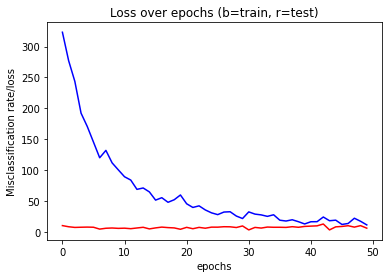

In [12]:
x = np.arange(epochs)
y_train = np.array(train_loss) 
y_test = np.array(test_loss)
plt.title('Loss over epochs (b=train, r=test)')
plt.xlabel('epochs')
plt.ylabel('Misclassification rate/loss')
plt.plot(x, y_train, c='b')
plt.plot(x, y_test, c='r')
plt.show()

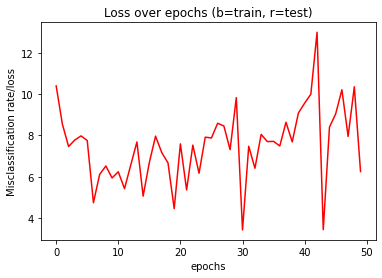

In [13]:
x = np.arange(epochs)
y_test = np.array(test_loss)
plt.title('Loss over epochs (b=train, r=test)')
plt.xlabel('epochs')
plt.ylabel('Misclassification rate/loss')
plt.plot(x, y_test, c='r')
plt.show()

In [69]:
net.to(torch.device("cpu")) 

correct = 0
total = 0
predict = []
true = []

def find_max_elem(array):
    _max = float('-inf')
    index = 0
    for i in range(len(array)):
        if array[i] > _max:
            index = i
            _max = array[i]
    return index
            
with torch.no_grad():
    for data in data_loader_test:
        images, labels = data
        outputs = net(images)

        for i in range(batch_size):
            try:
                true.append(int(labels[i]))
                predict.append(find_max_elem(outputs[i]))
                if find_max_elem(outputs[i]) == labels[i]:
                    correct += 1
                total+=1
            except:
                pass

    print(correct, total)

print('Accuracy on test images: %d %%' % (
    round(100 * correct / total)))

35 40
Accuracy on test images: 88 %


In [70]:
conf_matrix = confusion_matrix(true, predict)

class Confusion_matrix():
    def __init__(self):
        self.M = []
        self.class_map = {"Car": 0, "Truck": 1, "Bicycle": 2, "Dog": 3}

    def extract_all(self, CM):
        for k in range(4):
            tp, fn, fp, tn = 0, 0, 0, 0
            for i in range(4):
                for j in range(4):
                    if i == j and i == k:
                        tp = CM[i][j]
                    elif i == k and (j > i or j < i):
                        fn += CM[i][j]
                    elif j == k and (i > j or i < j):
                        fp += CM[i][j]
                    else:
                        tn += CM[i][j]
            self.M.append([tn, fp, fn, tp])  
            
            
        for i in range(4):
            position = list(self.class_map.values()).index(i)
            print("Class: ", list(self.class_map.keys())[position])
            print("[tn, fp, fn, tp]: ", self.M[i])
            print("Accuracy: ", self.accuracy(i))
            print("Misclassification: ", self.misclassification(i))
            print("Precision: ", self.precision(i))
            print("Recall: ", self.recall(i))
            print("*********************************************")
    
    def tn_fp_fn_tp(self, _class):
        return self.M[_class]
    
    def accuracy(self, _class):
        tn, fp, fn, tp = self.M[_class]
        return (tp+tn)/(tp+tn+fp+fn) * 100
    
    def misclassification(self, _class):
        tn, fp, fn, tp = self.M[_class]
        return (fp+fn)/(tp+tn+fp+fn) * 100
    
    def precision(self, _class):
        tn, fp, fn, tp = self.M[_class]
        return tp/(tp+fp) * 100
    
    def recall(self, _class):
        tn, fp, fn, tp = self.M[_class]
        return tp/(tp+fn) * 100

In [71]:
a = Confusion_matrix()
a.extract_all(conf_matrix)

Class:  Car
[tn, fp, fn, tp]:  [28, 2, 1, 9]
Accuracy:  92.5
Misclassification:  7.5
Precision:  81.81818181818183
Recall:  90.0
*********************************************
Class:  Truck
[tn, fp, fn, tp]:  [27, 3, 2, 8]
Accuracy:  87.5
Misclassification:  12.5
Precision:  72.72727272727273
Recall:  80.0
*********************************************
Class:  Bicycle
[tn, fp, fn, tp]:  [30, 0, 1, 9]
Accuracy:  97.5
Misclassification:  2.5
Precision:  100.0
Recall:  90.0
*********************************************
Class:  Dog
[tn, fp, fn, tp]:  [30, 0, 1, 9]
Accuracy:  97.5
Misclassification:  2.5
Precision:  100.0
Recall:  90.0
*********************************************


In [72]:
#PATH = "./CNNmodule1"
#torch.save(net.state_dict(), PATH)

In [18]:
#net = CNN()
#net.load_state_dict(torch.load(PATH))
#net.eval()

In [19]:
#calculating number of parameters in CNN
X = [(3, 32, 3),(32, 64, 3),(64, 64, 3)]
Y = [(9216,1028),(1028,128),(128,4)]
num_param = 0
for x in X:
    num_param += (x[2] * x[2] * x[0] + 1 )*x[1]
for y in Y:
    num_param += y[0] * y[1] + 1 * y[1]
num_param

9663624